In [ ]:
!pip -q install -U keras-tuner gputil

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import os
import time
import json
import platform
import numpy as np
import GPUtil
import pandas as pd
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import numpy as np, pandas as pd, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os, math, time, json, platform, timeit


In [ ]:

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Paths
BASE_PATH = "/content/drive/MyDrive/EdgeMeter_AIv2/data"
WIN_KEY   = "48to12"
WIN_TAG   = "48_12"

HP_PATH   = os.path.join(BASE_PATH, f"best_tinyformer_hp_{WIN_KEY}.json")
LOG_PATH  = os.path.join(BASE_PATH, "tinyformer_training_log_48_12.json")

# Loading Data
X_train = np.load(os.path.join(BASE_PATH, "X_train_48_12.npy"))
y_train = np.load(os.path.join(BASE_PATH, "y_train_48_12.npy"))
X_val   = np.load(os.path.join(BASE_PATH, "X_val_48_12.npy"))
y_val   = np.load(os.path.join(BASE_PATH, "y_val_48_12.npy"))
X_test  = np.load(os.path.join(BASE_PATH, "X_test_48_12.npy"))
y_test  = np.load(os.path.join(BASE_PATH, "y_test_48_12.npy"))

input_shape = X_train.shape[1:]   # (T, F)
timesteps, n_features = input_shape

In [5]:
# GPU info
gpus = tf.config.list_physical_devices('GPU')
print("GPUs visible to TF:", gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except Exception:
        pass
gpu_name = GPUtil.getGPUs()[0].name if GPUtil.getGPUs() else "None"
print("GPU in use:", gpu_name)


GPUs visible to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU in use: NVIDIA A100-SXM4-40GB


In [6]:
# Loading Best Hyperparameters
with open(os.path.join(BASE_PATH, "tinyformer_tuning_log_48to12.json")) as f:
    best_hp = json.load(f)

best_hps = best_hp["best_hyperparameters"]
print("Best HPs:", best_hps)


Best HPs: {'patch_size': 12, 'embed_dim': 64, 'num_heads': 4, 'key_dim': 48, 'attn_dropout': 0.1, 'ff_dim': 128, 'ff_dropout': 0.1, 'learning_rate': 0.001}


In [7]:
# Build Model
def patchify(x, patch_size):
    # x: (B, T, F) -> (B, P, patch_size*F), P = floor(T/patch_size)
    T = tf.shape(x)[1]
    F = tf.shape(x)[2]
    t_trim = (T // patch_size) * patch_size
    x = x[:, :t_trim, :]
    num_patches = t_trim // patch_size
    return tf.reshape(x, [tf.shape(x)[0], num_patches, patch_size * F])

def tinyformer_block(x, hp_dict):
    """PreNorm Transformer encoder: MHA + FFN + residuals (matches tuning_tinyformer_v2)."""
    embed_dim   = int(hp_dict["embed_dim"])
    num_heads   = int(hp_dict["num_heads"])
    key_dim     = int(hp_dict["key_dim"])
    attn_drop   = float(hp_dict["attn_dropout"])
    ff_dim      = int(hp_dict["ff_dim"])
    ff_dropout  = float(hp_dict["ff_dropout"])

    # Project patches to embed_dim (stable dims for MHA/FFN)
    x = layers.Dense(embed_dim)(x)

    # PreNorm + MHA
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim, dropout=attn_drop
    )(y, y)
    x = layers.Add()([x, y])  # residual

    # PreNorm + FFN
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(ff_dim, activation="gelu")(y)
    y = layers.Dropout(ff_dropout)(y)
    y = layers.Dense(embed_dim)(y)
    x = layers.Add()([x, y])  # residual

    return x

def build_tinyformer_from_hp(input_shape, hp_dict):
    T, F = input_shape
    patch_size = int(hp_dict["patch_size"])
    assert T // patch_size > 0, f"patch_size {patch_size} too large for T={T}"

    inputs = keras.Input(shape=(T, F))
    x = layers.Lambda(lambda t: patchify(t, patch_size))(inputs)  # (B, P, patch_size*F)

    # single TinyFormer block
    x = tinyformer_block(x, hp_dict)

    # pool + predict 12 steps
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(12)(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=float(hp_dict["learning_rate"])),
        loss="mse",
        metrics=["mae"]
    )
    return model

model = build_tinyformer_from_hp(input_shape, best_hps)
model.summary()

# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4, 132)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4, 64)     │      8,512 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 4, 64)     │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 64)     │     49,792 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 64)     │          0 │ dense[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 64)     │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4, 128)    │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 128)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4, 64)     │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 64)     │          0 │ add[0][0],        │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12)        │        780 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 75,916 (296.55 KB)

 Trainable params: 75,916 (296.55 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train
start_time = time.time()
device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
with tf.device(device):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=512,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
end_time = time.time()

Epoch 1/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - loss: 0.1713 - mae: 0.1768 - val_loss: 0.0458 - val_mae: 0.1168 - learning_rate: 0.0010
Epoch 2/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 0.0454 - mae: 0.1154 - val_loss: 0.0433 - val_mae: 0.1221 - learning_rate: 0.0010
Epoch 3/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 0.0439 - mae: 0.1118 - val_loss: 0.0433 - val_mae: 0.1237 - learning_rate: 0.0010
Epoch 4/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - loss: 0.0433 - mae: 0.1101 - val_loss: 0.0419 - val_mae: 0.1090 - learning_rate: 0.0010
Epoch 5/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 0.0430 - mae: 0.1093 - val_loss: 0.0424 - val_mae: 0.1155 - learning_rate: 0.0010
Epoch 6/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 0.0428 - mae: 0.1088 - val_loss: 0.0428 - val_mae: 0.1218 - learning_rate: 0.0010
Epoch 7/50
20938/20938 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 0.0427 - mae: 0.1085 - val_loss: 0.0422 - val_mae: 0

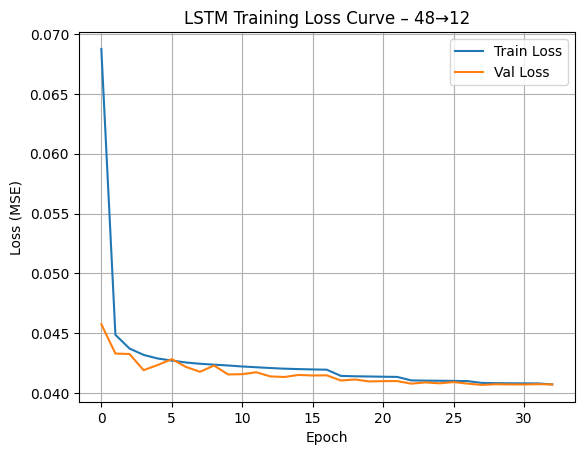

In [9]:
# Saving Training History
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(os.path.join(BASE_PATH, "TinyFormer_Training_History_48_12.csv"))

# Training Curve
plt.figure()
plt.plot(hist_df["loss"], label="Train Loss")
plt.plot(hist_df["val_loss"], label="Val Loss")
plt.title("LSTM Training Loss Curve – 48→12")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(BASE_PATH, "TinyFormer_Training_Curve_48_12.png"))
plt.show()

In [10]:


# Saving GPU-trained weights
WEIGHTS_PATH = os.path.join(BASE_PATH, "TinyFormer_48_12_trained.weights.h5")
model.save_weights(WEIGHTS_PATH)
print(f" Saved GPU-trained weights to {WEIGHTS_PATH}")



 Saved GPU-trained weights to /content/drive/MyDrive/EdgeMeter_AIv2/data/TinyFormer_48_12_trained.weights.h5


In [11]:
# Evaluation
y_pred = model.predict(X_test, batch_size=1024, verbose=0)
test_mae  = mean_absolute_error(y_test, y_pred)
mse       = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(mse)
test_r2   = r2_score(y_test, y_pred)


In [12]:
SAVE_DIR   = os.path.join(BASE_PATH, "Final_TinyFormer_Model_48_12")
SAVE_H5    = os.path.join(BASE_PATH, "Final_TinyFormer_Model_48_12.h5")
SAVE_KERAS = os.path.join(BASE_PATH, "Final_TinyFormer_Model_48_12.keras")

model.export(SAVE_DIR)   # TF SavedModel (Keras 3)
model.save(SAVE_H5)      # HDF5
model.save(SAVE_KERAS)   # .keras


Saved artifact at '/content/drive/MyDrive/EdgeMeter_AIv2/data/Final_TinyFormer_Model_48_12'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 11), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  140618115659536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115661648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115661072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115660112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115661456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115661264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115659728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115660880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618109632784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618109633360: TensorSpec(shape

In [13]:
# Model Size
def get_dir_size_mb(path):
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size / 1e6

size_savedmodel_mb = get_dir_size_mb(SAVE_DIR)
size_h5_mb    = os.path.getsize(SAVE_H5) / 1e6 if os.path.exists(SAVE_H5) else None
size_keras_mb = os.path.getsize(SAVE_KERAS) / 1e6 if os.path.exists(SAVE_KERAS) else None



   usage_bin       MAE      RMSE        R2
0          0  0.044556  0.095786  0.225426
1          1  0.067230  0.126284  0.228321
2          2  0.086579  0.157026  0.294525
3          3  0.129200  0.234209  0.310954
4          4  0.208217  0.354988  0.719386


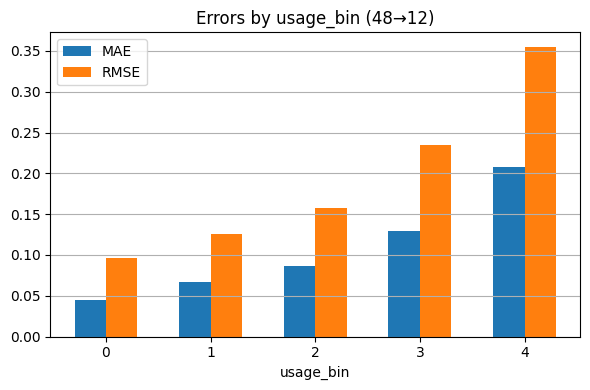

In [14]:
# Error by usage bin
USAGE_BIN_IDX = 10
bins = X_test[:, -1, USAGE_BIN_IDX].astype(int)
rows = []
for b in np.sort(np.unique(bins)):
    m = (bins == b)
    yt, yp = y_test[m], y_pred[m]
    if yt.size == 0:
        continue
    rows.append({
        'usage_bin': int(b),
        'MAE': mean_absolute_error(yt, yp),
        'RMSE': np.sqrt(mean_squared_error(yt, yp)),
        'R2': r2_score(yt, yp)
    })
by_bin = pd.DataFrame(rows).sort_values('usage_bin')
by_bin_csv = os.path.join(BASE_PATH, "TinyFormer_metrics_by_usage_bin_48_12.csv")
by_bin.to_csv(by_bin_csv, index=False)
print(by_bin)

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_bin['usage_bin']-0.15, by_bin['MAE'],  width=0.3, label='MAE')
ax.bar(by_bin['usage_bin']+0.15, by_bin['RMSE'], width=0.3, label='RMSE')
ax.set_xlabel('usage_bin'); ax.set_title('Errors by usage_bin (48→12)')
ax.grid(True, axis='y'); ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(BASE_PATH, "TinyFormer_errors_by_usage_bin_48_12.png"))
plt.show()



In [15]:
# Residual diagnostics by hour‑of‑day
HOUR_IDX = 5
hours    = np.rint(X_test[:, -1, HOUR_IDX] * 23).astype(int).clip(0,23)
resid    = (y_test - y_pred).reshape(len(y_test), 12)
abs_res  = np.abs(resid).mean(axis=1)

df_hr = pd.DataFrame({'hour': hours, 'abs_resid': abs_res})
by_hr = df_hr.groupby('hour', as_index=False)['abs_resid'].mean()
by_hr_csv = os.path.join(BASE_PATH, "TinyFormer_abs_residual_by_hour_48_12.csv")
by_hr.to_csv(by_hr_csv, index=False)
print(by_hr.head())


   hour  abs_resid
0     0   0.058614
1    23   0.108316


In [16]:
# Inference Time
sample_input = tf.convert_to_tensor(X_test[:1])
t0 = timeit.default_timer(); _ = model(sample_input); t1 = timeit.default_timer()
inference_time = (t1 - t0) * 1000.0


In [17]:
# Log Final Metrics
gpus = GPUtil.getGPUs()
log_data = {
    "model_name": "TinyFormer_Final_48_12",
    "task": "Smart Meter Energy Forecasting",
    "tuning_type": "BayesianOptimization",
    "test_mae": float(test_mae),
    "test_rmse": float(test_rmse),
    "test_r2": float(test_r2),
    "params": int(model.count_params()),
    "model_size_mb_savedmodel": float(size_savedmodel_mb),
    "model_size_mb_h5": float(size_h5_mb) if size_h5_mb is not None else None,
    "model_size_mb_keras": float(size_keras_mb) if size_keras_mb is not None else None,
    "inference_time_ms": float(inference_time),
    "training_time_minutes": round((end_time - start_time) / 60, 2),
    "input_shape": list(map(int, X_train.shape[1:])),
    # TinyFormer-specific HPs
    "patch_size":    int(best_hps["patch_size"]),
    "embed_dim":     int(best_hps["embed_dim"]),
    "num_heads":     int(best_hps["num_heads"]),
    "key_dim":       int(best_hps["key_dim"]),
    "attn_dropout":  float(best_hps["attn_dropout"]),
    "ff_dim":        int(best_hps["ff_dim"]),
    "ff_dropout":    float(best_hps["ff_dropout"]),
    "learning_rate": float(best_hps["learning_rate"]),
    "system_info": {
        "platform": platform.system(),
        "platform_version": platform.version(),
        "processor": platform.processor(),
        "gpu_used": gpus[0].name if gpus else "None"
    }
}
with open(os.path.join(BASE_PATH, "TinyFormer_Final_Log_48_12.json"), "w") as f:
    json.dump(log_data, f, indent=4)


In [18]:
# Saving Predictions
np.savetxt(os.path.join(BASE_PATH, "TinyFormer_y_pred_48_12.csv"), y_pred, delimiter=",")


In [19]:

# Converting model to TFLite version for edge
tf.keras.backend.clear_session()
gc.collect()
try:
    tf.config.experimental.set_visible_devices([], 'GPU')
    print(" GPU hidden for CPU rebuild.")
except Exception as e:
    print("⚠ Could not hide GPU (not critical for TinyFormer):", e)

with tf.device("/CPU:0"):
    cpu_model = build_tinyformer_from_hp(input_shape, best_hps)
    cpu_model.load_weights(WEIGHTS_PATH)

SAVE_DIR_CPU = os.path.join(BASE_PATH, "Final_TinyFormer_Model_48_12_CPU_clean")
cpu_model.export(SAVE_DIR_CPU)
print(" CPU-only SavedModel at:", SAVE_DIR_CPU)

# TFLite convert
converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_DIR_CPU)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
try:
    tflite_model = converter.convert()
except Exception as e:
    print("Builtins-only failed, retrying with SELECT_TF_OPS. Error:", e)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    tflite_model = converter.convert()

TFLITE_PATH = os.path.join(BASE_PATH, "Final_TinyFormer_Model_48_12.tflite")
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)
print(f" TFLite model saved at: {TFLITE_PATH}")


⚠ Could not hide GPU (not critical for TinyFormer): Visible devices cannot be modified after being initialized


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/content/drive/MyDrive/EdgeMeter_AIv2/data/Final_TinyFormer_Model_48_12_CPU_clean'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 11), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  140618035687120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618035685968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618035688656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618035689040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115654736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115656272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115656656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115655504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115658960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140618115654160: Tensor

In [20]:
# Quick TFLite Sanity Check
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
inp = interpreter.get_input_details()[0]
out = interpreter.get_output_details()[0]
sample = X_test[:1].astype(np.float32)
interpreter.set_tensor(inp["index"], sample)
interpreter.invoke()
pred = interpreter.get_tensor(out["index"])
print("TFLite inference OK | Output shape:", pred.shape)
print("First prediction row:", pred[0])


✅ TFLite inference OK | Output shape: (1, 12)
First prediction row: [0.05396629 0.06241236 0.07038567 0.08539005 0.1122682  0.09858964
 0.10434936 0.11289707 0.09014767 0.09222621 0.08354095 0.1043753 ]


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
